In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt # plotting library
%matplotlib inline


from keras.models import Sequential
from keras.layers import Dense , Activation, Dropout
from keras.optimizers import Adam ,RMSprop
from keras import  backend as K


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:

from keras.datasets import mnist


# load dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data()



# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))



# count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))


11490434/11490434 [==============================] - 0s 0us/step
Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}

Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


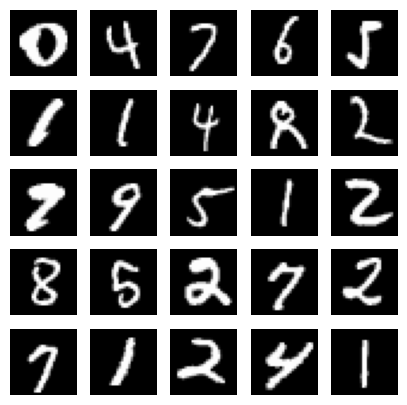

In [4]:
# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]


# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical, plot_model

In [6]:
# compute the number of labels
num_labels = len(np.unique(y_train))

In [7]:
# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
input_size

784

In [9]:
# resize and normalize
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

In [10]:
# network parameters
batch_size = 128
hidden_units = 256
dropout = 0.45

In [11]:
pip install larq


  Obtaining dependency information for larq from https://files.pythonhosted.org/packages/ee/a7/73f3fcfea3b618f755dcd621d43073a3367428e9d16b7b6e0c34d5307c73/larq-0.13.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
import tensorflow as tf
import larq as lq

def reshape_input_data(X):
    return tf.reshape(X, (-1, 28, 28, 1))

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(reshape_input_data, input_shape=(784,)),
    lq.layers.QuantConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(10, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 28, 28, 1)         0         
                                                                 
 quant_conv2d (QuantConv2D)  (None, 26, 26, 128)       1152      
                                                                 
 batch_normalization (Batch  (None, 26, 26, 128)       384       
 Normalization)                                                  
                                                                 
 quant_conv2d_1 (QuantConv2  (None, 26, 26, 128)       147456    
 D)                                                              
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 128)       0         
 D)                                                              
                                                        

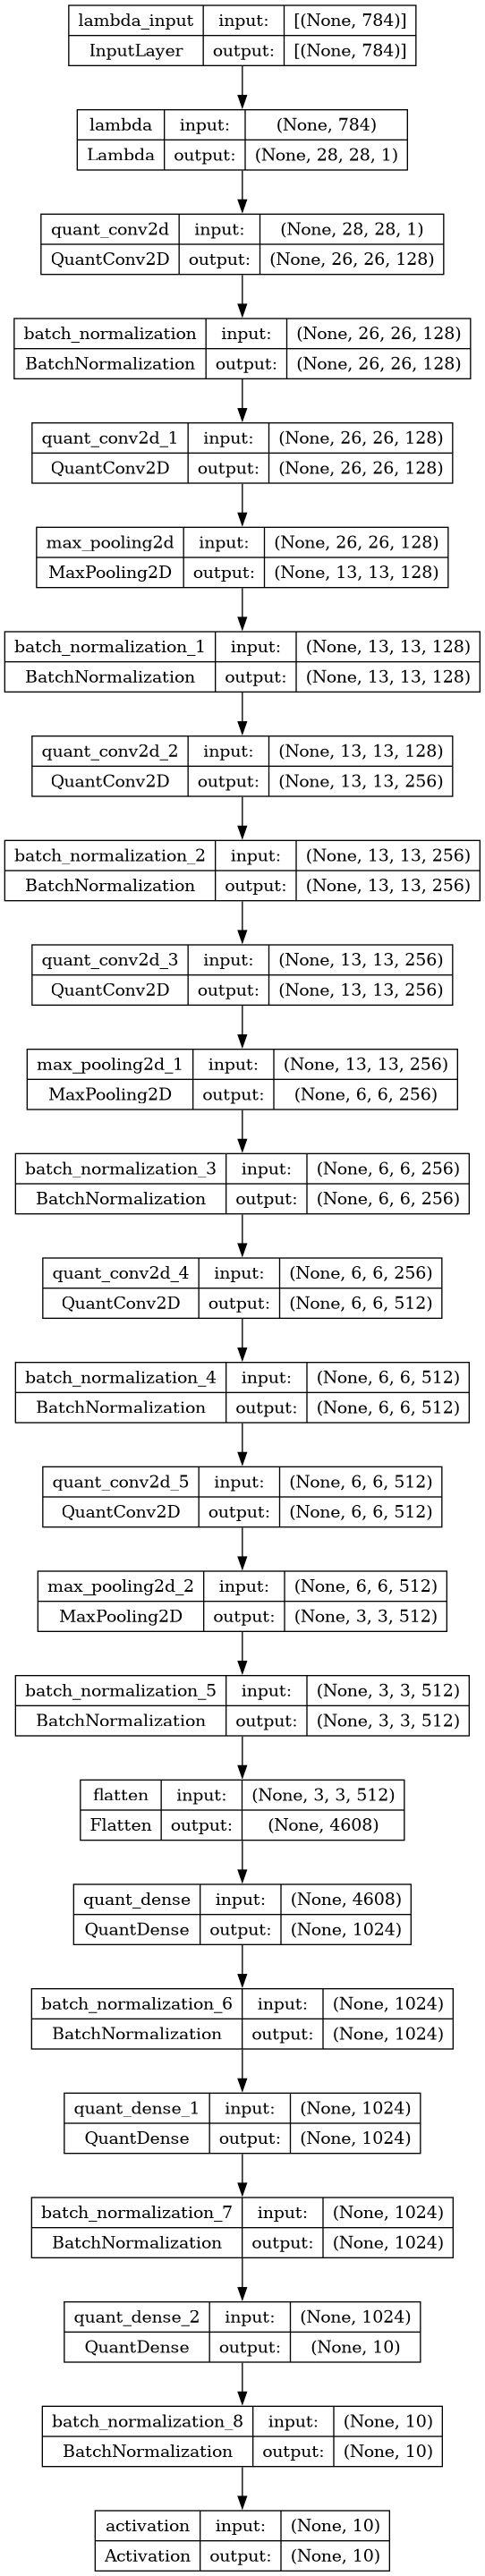

In [14]:
plot_model(model, to_file='mlp-mnist.png', show_shapes=True)

In [15]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
model.fit(x_train, y_train, epochs=20, batch_size=batch_size)

Epoch 1/20
469/469 [==============================] - 41s 64ms/step - loss: 0.4405 - accuracy: 0.9610
Epoch 2/20
469/469 [==============================] - 29s 62ms/step - loss: 0.3475 - accuracy: 0.9879
Epoch 3/20
469/469 [==============================] - 30s 64ms/step - loss: 0.3370 - accuracy: 0.9907
Epoch 4/20
469/469 [==============================] - 31s 66ms/step - loss: 0.3294 - accuracy: 0.9932
Epoch 5/20
469/469 [==============================] - 31s 66ms/step - loss: 0.3264 - accuracy: 0.9941
Epoch 6/20
469/469 [==============================] - 31s 66ms/step - loss: 0.3229 - accuracy: 0.9951
Epoch 7/20
469/469 [==============================] - 31s 66ms/step - loss: 0.3210 - accuracy: 0.9961
Epoch 8/20
469/469 [==============================] - 31s 66ms/step - loss: 0.3206 - accuracy: 0.9965
Epoch 9/20
469/469 [==============================] - 31s 66ms/step - loss: 0.3184 - accuracy: 0.9972
Epoch 10/20
469/469 [==============================] - 31s 66ms/step - loss: 0.317

In [17]:
loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

79/79 [==============================] - 2s 24ms/step - loss: 0.3049 - accuracy: 0.9937

Test accuracy: 99.4%


In [18]:
from keras.regularizers import l2
model.add(Dense(hidden_units,
                kernel_regularizer=l2(0.001),
                input_dim=input_size))